In [ ]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Aug-2022/train.csv'
file_key_2 = 'Tabular-Playground-Aug-2022/test.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

## Reading data-files
train = pd.read_csv(file_content_stream_1)
train = train.drop(columns = ['id'], axis = 1)

test = pd.read_csv(file_content_stream_2)
test = test.drop(columns = ['id'], axis = 1)

## Changing labels to dummies
train_dummies = pd.get_dummies(train[['attribute_0']])
train = train.drop(columns = ['product_code', 'attribute_0', 'attribute_1'], axis = 1)
train = pd.concat([train, train_dummies], axis = 1)

test_dummies = pd.get_dummies(test[['attribute_0']])
test = test.drop(columns = ['product_code', 'attribute_0', 'attribute_1'], axis = 1)
test = pd.concat([test, test_dummies], axis = 1)

## Filling missing values with kNN
knn_imputer = KNNImputer(n_neighbors = 5, weights = 'distance')
train = pd.DataFrame(knn_imputer.fit_transform(train), columns = train.columns)
test = pd.DataFrame(knn_imputer.fit_transform(test), columns = test.columns)

## Engineering features
train['feature_1'] = np.where(train['loading'] < 150, 0, 1)
test['feature_1'] = np.where(test['loading'] < 150, 0, 1)

## Defining input and target variables
X = train[['loading', 'measurement_2', 'measurement_4', 'measurement_5',
           'measurement_6', 'measurement_7', 'measurement_8', 'measurement_15',
           'measurement_17', 'feature_1']]
# X = train.drop(columns = ['failure'], axis = 1)
Y = train['failure']

In [ ]:
X.describe()

In [ ]:
## Building Random Forest model
RF_md = RandomForestClassifier(n_estimators = 300, max_depth = 3, criterion = 'gini').fit(X, Y)

In [ ]:
importance = pd.DataFrame({'feature': X.columns, 'Imp': RF_md.feature_importances_})
importance = importance.sort_values(by = 'Imp', ascending = False)
importance

In [ ]:
from sklearn.feature_selection import RFECV

## Running RFE with Random forest
RF_auto_feature = RFECV(estimator = RandomForestClassifier(n_estimators = 300, max_depth = 3), step = 1, scoring = 'roc_auc', min_features_to_select = 10, cv = 3, n_jobs = -1).fit(X, Y)

## Appending results 
X.columns[RF_auto_feature.support_]

In [ ]:
X.columns[RF_auto_feature.support_]

In [ ]:
X.describe()

In [ ]:
test.describe()

In [ ]:
## Building the decision tree on the train data-frame
tree_md = DecisionTreeClassifier(max_depth = 3).fit(X, Y)

## Visualizing the decision-tree model 
fig = plt.figure(figsize = (25, 15))
plot_tree(tree_md, feature_names = X.columns, filled = True)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (18, 12))

sns.boxplot(ax = axes[0], x = 'failure', y = 'loading', hue = 'failure', data = train)
sns.boxplot(ax = axes[1], x = 'failure', y = 'measurement_3', hue = 'failure', data = train)

In [ ]:
train.head()

In [ ]:
train['attribute_1'].value_counts()

In [ ]:
test['attribute_1'].value_counts()

In [ ]:
test.head()

In [ ]:
test.describe()

In [ ]:
## Defining the model 
knn_imputer = KNNImputer(n_neighbors = 5, weights = 'uniform')
X_new = knn_imputer.fit_transform(X)

In [ ]:
X_new = pd.DataFrame(X_new)

In [ ]:
X_new.head()

In [ ]:
train.head()

In [ ]:
train.shape

In [ ]:
train.describe()

In [ ]:
test.head()

In [ ]:
test.describe()

In [ ]:
test.shape

In [ ]:
train['attribute_0'].value_counts()

In [ ]:
train['attribute_1'].value_counts()

In [ ]:
test['attribute_0'].value_counts()

In [ ]:
test['attribute_1'].value_counts()

In [ ]:
X.head()

In [ ]:
X.shape

In [ ]:
test.head()

In [ ]:
train.head()

In [ ]:
train['attribute_1'].value_counts()

In [ ]:
train.describe()

In [ ]:
train['product_code'].value_counts()

In [ ]:
train['attribute_0'].value_counts()

In [ ]:
train['attribute_1'].value_counts()

In [ ]:
test.head()

In [ ]:
train_dummies = pd.get_dummies(train[['product_code', 'attribute_0', 'attribute_1']])
train_dummies.head()

In [ ]:
train_dummies = pd.get_dummies(train[['product_code', 'attribute_0', 'attribute_1']])
train = train.drop(columns = ['product_code', 'attribute_0', 'attribute_1'], axis = 1)
train = pd.concat([train, train_dummies], axis = 1)
train.head()

In [ ]:
train['failure'].value_counts() / train.shape[0]

In [ ]:
test_dummies = pd.get_dummies(test[['product_code', 'attribute_0', 'attribute_1']])
test = test.drop(columns = ['product_code', 'attribute_0', 'attribute_1'], axis = 1)
test = pd.concat([test, test_dummies], axis = 1)
test.head()

# Logistic Regression

In [1]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Aug-2022/train.csv'
file_key_2 = 'Tabular-Playground-Aug-2022/test.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

## Reading data-files
train = pd.read_csv(file_content_stream_1)
train = train.drop(columns = ['id'], axis = 1)

test = pd.read_csv(file_content_stream_2)
test_id = test['id']
test = test.drop(columns = ['id'], axis = 1)

## Changing labels to dummies
train_dummies = pd.get_dummies(train[['attribute_0']])
train = train.drop(columns = ['product_code', 'attribute_0', 'attribute_1', 'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2'], axis = 1)
train = pd.concat([train, train_dummies], axis = 1)

test_dummies = pd.get_dummies(test[['attribute_0']])
test = test.drop(columns = ['product_code', 'attribute_0', 'attribute_1', 'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2'], axis = 1)
test = pd.concat([test, test_dummies], axis = 1)

## Filling missing values with kNN
knn_imputer = KNNImputer(n_neighbors = 5, weights = 'distance')
train = pd.DataFrame(knn_imputer.fit_transform(train), columns = train.columns)
test = pd.DataFrame(knn_imputer.fit_transform(test), columns = test.columns)

## Defining input and target variables
X = train.drop(columns = ['failure'], axis = 1)
Y = train['failure']

## Scaling inputs to 0-1
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
test = pd.DataFrame(scaler.fit_transform(test), columns = test.columns)

## Defining the hyper-parameter grid
logistic_param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
                       'C': [0.001, 0.01, 0.1, 1, 10, 100],
                       'solver': ['liblinear', 'sag', 'saga']}

## Performing grid search with 5 folds
logistic_grid_search = GridSearchCV(LogisticRegression(max_iter = 1000), logistic_param_grid, cv = 5, scoring = 'roc_auc', n_jobs = -1, verbose = 1).fit(X, Y)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
120 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-pack

In [2]:
best_params = logistic_grid_search.best_params_
print(best_params)

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


In [3]:
best_score = logistic_grid_search.best_score_
print('The best area under the ROC cure is:', best_score)

The best area under the ROC cure is: 0.5898217001986322


/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

In [4]:
## Extracting the best model
logistic_md = logistic_grid_search.best_estimator_
print(logistic_md)

LogisticRegression(C=0.1, max_iter=1000, penalty='l1', solver='liblinear')


In [11]:
logit_md = LogisticRegression(C = 0.1, penalty = 'l1', solver = 'liblinear', max_iter = 1000).fit(X, Y)
coefs =  pd.DataFrame({'feature': X.columns, 'est_coef': abs(logit_md.coef_.flatten())})
coefs = coefs.sort_values(by = 'est_coef', ascending = False).reset_index(drop = True)
coefs

,feature,est_coef
0,loading,2.467620
1,measurement_17,0.491704
2,measurement_4,0.196130
3,attribute_0_material_5,0.077022
4,measurement_11,0.057501
5,measurement_9,0.050645
6,measurement_7,0.000000
7,measurement_8,0.000000
8,measurement_10,0.000000
9,measurement_3,0.000000


In [16]:
logit_1 = LogisticRegression(C = 0.1, penalty = 'l1', solver = 'liblinear', max_iter = 1000).fit(X[coefs['feature'].loc[0:5].values], Y)
logit_1_pred = logit_1.predict_proba(X[coefs['feature'].loc[0:5].values])[:, 1]
logit_1_score = roc_auc_score(Y, logit_1_pred)
print('The area under the ROC curve is:', logit_1_score)

## Predicting on test with best model 
logit_1_test_pred = logit_1.predict_proba(test[coefs['feature'].loc[0:5].values])[:, 1] 

## Defining data-frame to be exported
data_out = pd.DataFrame({'id': test_id, 'failure': logit_1_test_pred})
data_out.to_csv('Logistic_submission_top_5.csv', index = False)

The area under the ROC curve is: 0.5917109597291497


In [17]:
logit_2 = LogisticRegression(C = 0.1, penalty = 'l1', solver = 'liblinear', max_iter = 1000).fit(X[coefs['feature'].loc[0:6].values], Y)
logit_2_pred = logit_2.predict_proba(X[coefs['feature'].loc[0:6].values])[:, 1]
logit_2_score = roc_auc_score(Y, logit_2_pred)
print('The area under the ROC curve is:', logit_2_score)

## Predicting on test with best model 
logit_2_test_pred = logit_2.predict_proba(test[coefs['feature'].loc[0:6].values])[:, 1] 

## Defining data-frame to be exported
data_out = pd.DataFrame({'id': test_id, 'failure': logit_2_test_pred})
data_out.to_csv('Logistic_submission_top_6.csv', index = False)

The area under the ROC curve is: 0.5917147420076923


In [8]:
logit_3 = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear', max_iter = 1000).fit(X[coefs['feature'].loc[0:7].values], Y)
logit_3_pred = logit_3.predict_proba(X[coefs['feature'].loc[0:7].values])[:, 1]
logit_3_score = roc_auc_score(Y, logit_3_pred)
print('The area under the ROC curve is:', logit_3_score)

## Predicting on test with best model 
logit_3_test_pred = logit_3.predict_proba(test[coefs['feature'].loc[0:7].values])[:, 1] 

## Defining data-frame to be exported
# data_out = pd.DataFrame({'id': test_id, 'failure': logit_3_test_pred})
# data_out.to_csv('Logistic_submission_3.csv', index = False)

The area under the ROC curve is: 0.5920820884073509


In [9]:
logit_4 = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear', max_iter = 1000).fit(X[coefs['feature'].loc[0:8].values], Y)
logit_4_pred = logit_4.predict_proba(X[coefs['feature'].loc[0:8].values])[:, 1]
logit_4_score = roc_auc_score(Y, logit_4_pred)
print('The area under the ROC curve is:', logit_4_score)

## Predicting on test with best model 
logit_4_test_pred = logit_4.predict_proba(test[coefs['feature'].loc[0:8].values])[:, 1] 

## Defining data-frame to be exported
# data_out = pd.DataFrame({'id': test_id, 'failure': logit_4_test_pred})
# data_out.to_csv('Logistic_submission_4.csv', index = False)

The area under the ROC curve is: 0.5921029205544915


In [10]:
logit_5 = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear', max_iter = 1000).fit(X[coefs['feature'].loc[0:9].values], Y)
logit_5_pred = logit_5.predict_proba(X[coefs['feature'].loc[0:9].values])[:, 1]
logit_5_score = roc_auc_score(Y, logit_5_pred)
print('The area under the ROC curve is:', logit_5_score)

## Predicting on test with best model 
logit_5_test_pred = logit_5.predict_proba(test[coefs['feature'].loc[0:9].values])[:, 1] 

## Defining data-frame to be exported
# data_out = pd.DataFrame({'id': test_id, 'failure': logit_5_test_pred})
# data_out.to_csv('Logistic_submission_5.csv', index = False)

The area under the ROC curve is: 0.592213952006473


In [17]:
logit_6 = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear', max_iter = 1000).fit(X[coefs['feature'].loc[0:10].values], Y)
logit_6_pred = logit_6.predict_proba(X[coefs['feature'].loc[0:10].values])[:, 1]
logit_6_score = roc_auc_score(Y, logit_6_pred)
print('The area under the ROC curve is:', logit_6_score)

## Predicting on test with best model 
logit_6_test_pred = logit_6.predict_proba(test[coefs['feature'].loc[0:10].values])[:, 1] 

## Defining data-frame to be exported
# data_out = pd.DataFrame({'id': test_id, 'failure': logit_6_test_pred})
# data_out.to_csv('Logistic_submission_6.csv', index = False)

The area under the ROC curve is: 0.5932685054175725


In [18]:
logit_7 = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear', max_iter = 1000).fit(X[coefs['feature'].loc[0:11].values], Y)
logit_7_pred = logit_7.predict_proba(X[coefs['feature'].loc[0:11].values])[:, 1]
logit_7_score = roc_auc_score(Y, logit_7_pred)
print('The area under the ROC curve is:', logit_7_score)

## Predicting on test with best model 
logit_7_test_pred = logit_7.predict_proba(test[coefs['feature'].loc[0:11].values])[:, 1] 

## Defining data-frame to be exported
# data_out = pd.DataFrame({'id': test_id, 'failure': logit_7_test_pred})
# data_out.to_csv('Logistic_submission_7.csv', index = False)

The area under the ROC curve is: 0.5932727446156705


In [19]:
logit_8 = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear', max_iter = 1000).fit(X[coefs['feature'].loc[0:12].values], Y)
logit_8_pred = logit_8.predict_proba(X[coefs['feature'].loc[0:12].values])[:, 1]
logit_8_score = roc_auc_score(Y, logit_8_pred)
print('The area under the ROC curve is:', logit_8_score)

## Predicting on test with best model 
logit_8_test_pred = logit_8.predict_proba(test[coefs['feature'].loc[0:12].values])[:, 1] 

## Defining data-frame to be exported
# data_out = pd.DataFrame({'id': test_id, 'failure': logit_8_test_pred})
# data_out.to_csv('Logistic_submission_8.csv', index = False)

The area under the ROC curve is: 0.5932892106426143


In [21]:
logit_9 = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear', max_iter = 1000).fit(X[coefs['feature'].loc[0:13].values], Y)
logit_9_pred = logit_9.predict_proba(X[coefs['feature'].loc[0:13].values])[:, 1]
logit_9_score = roc_auc_score(Y, logit_9_pred)
print('The area under the ROC curve is:', logit_9_score)

## Predicting on test with best model 
logit_9_test_pred = logit_9.predict_proba(test[coefs['feature'].loc[0:13].values])[:, 1] 

## Defining data-frame to be exported
# data_out = pd.DataFrame({'id': test_id, 'failure': logit_9_test_pred})
# data_out.to_csv('Logistic_submission_9.csv', index = False)

The area under the ROC curve is: 0.5935365141212808


In [22]:
logit_10 = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear', max_iter = 1000).fit(X[coefs['feature'].loc[0:14].values], Y)
logit_10_pred = logit_10.predict_proba(X[coefs['feature'].loc[0:14].values])[:, 1]
logit_10_score = roc_auc_score(Y, logit_10_pred)
print('The area under the ROC curve is:', logit_10_score)

## Predicting on test with best model 
logit_10_test_pred = logit_10.predict_proba(test[coefs['feature'].loc[0:14].values])[:, 1] 

## Defining data-frame to be exported
# data_out = pd.DataFrame({'id': test_id, 'failure': logit_10_test_pred})
# data_out.to_csv('Logistic_submission_10.csv', index = False)

The area under the ROC curve is: 0.5936143258292842


In [38]:
logit_11 = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear', max_iter = 1000).fit(X[coefs['feature'].loc[0:15].values], Y)
logit_11_pred = logit_11.predict_proba(X[coefs['feature'].loc[0:15].values])[:, 1]
logit_11_score = roc_auc_score(Y, logit_11_pred)
print('The area under the ROC curve is:', logit_11_score)

## Predicting on test with best model 
logit_11_test_pred = logit_11.predict_proba(test[coefs['feature'].loc[0:15].values])[:, 1] 

## Defining data-frame to be exported
data_out = pd.DataFrame({'id': test_id, 'failure': logit_11_test_pred})
data_out.to_csv('Logistic_submission_11.csv', index = False)

The area under the ROC curve is: 0.593843741753501


In [39]:
logit_12 = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear', max_iter = 1000).fit(X[coefs['feature'].loc[0:16].values], Y)
logit_12_pred = logit_12.predict_proba(X[coefs['feature'].loc[0:16].values])[:, 1]
logit_12_score = roc_auc_score(Y, logit_12_pred)
print('The area under the ROC curve is:', logit_12_score)

## Predicting on test with best model 
logit_12_test_pred = logit_12.predict_proba(test[coefs['feature'].loc[0:16].values])[:, 1] 

## Defining data-frame to be exported
data_out = pd.DataFrame({'id': test_id, 'failure': logit_12_test_pred})
data_out.to_csv('Logistic_submission_12.csv', index = False)

The area under the ROC curve is: 0.5938162335039666


In [25]:
logit_13 = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear', max_iter = 1000).fit(X[coefs['feature'].loc[0:17].values], Y)
logit_13_pred = logit_13.predict_proba(X[coefs['feature'].loc[0:17].values])[:, 1]
logit_13_score = roc_auc_score(Y, logit_13_pred)
print('The area under the ROC curve is:', logit_13_score)

## Predicting on test with best model 
logit_13_test_pred = logit_13.predict_proba(test[coefs['feature'].loc[0:17].values])[:, 1] 

## Defining data-frame to be exported
# data_out = pd.DataFrame({'id': test_id, 'failure': logit_13_test_pred})
# data_out.to_csv('Logistic_submission_13.csv', index = False)

The area under the ROC curve is: 0.5937585262564042


In [26]:
logit_14 = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear', max_iter = 1000).fit(X[coefs['feature'].loc[0:18].values], Y)
logit_14_pred = logit_14.predict_proba(X[coefs['feature'].loc[0:18].values])[:, 1]
logit_14_score = roc_auc_score(Y, logit_14_pred)
print('The area under the ROC curve is:', logit_14_score)

## Predicting on test with best model 
logit_14_test_pred = logit_14.predict_proba(test[coefs['feature'].loc[0:18].values])[:, 1] 

## Defining data-frame to be exported
# data_out = pd.DataFrame({'id': test_id, 'failure': logit_14_test_pred})
# data_out.to_csv('Logistic_submission_14.csv', index = False)

The area under the ROC curve is: 0.5937601339363217


In [27]:
logit_15 = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear', max_iter = 1000).fit(X[coefs['feature'].loc[0:19].values], Y)
logit_15_pred = logit_15.predict_proba(X[coefs['feature'].loc[0:19].values])[:, 1]
logit_15_score = roc_auc_score(Y, logit_15_pred)
print('The area under the ROC curve is:', logit_15_score)

## Predicting on test with best model 
logit_15_test_pred = logit_15.predict_proba(test[coefs['feature'].loc[0:19].values])[:, 1] 

## Defining data-frame to be exported
# data_out = pd.DataFrame({'id': test_id, 'failure': logit_15_test_pred})
# data_out.to_csv('Logistic_submission_15.csv', index = False)

The area under the ROC curve is: 0.5937781145669769


In [28]:
logit_16 = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear', max_iter = 1000).fit(X[coefs['feature'].loc[0:20].values], Y)
logit_16_pred = logit_16.predict_proba(X[coefs['feature'].loc[0:20].values])[:, 1]
logit_16_score = roc_auc_score(Y, logit_16_pred)
print('The area under the ROC curve is:', logit_16_score)

## Predicting on test with best model 
logit_16_test_pred = logit_16.predict_proba(test[coefs['feature'].loc[0:20].values])[:, 1] 

## Defining data-frame to be exported
# data_out = pd.DataFrame({'id': test_id, 'failure': logit_16_test_pred})
# data_out.to_csv('Logistic_submission_16.csv', index = False)

The area under the ROC curve is: 0.5937811522358737


In [40]:
logit_17 = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear', max_iter = 1000).fit(X[coefs['feature'].loc[0:21].values], Y)
logit_17_pred = logit_17.predict_proba(X[coefs['feature'].loc[0:21].values])[:, 1]
logit_17_score = roc_auc_score(Y, logit_17_pred)
print('The area under the ROC curve is:', logit_17_score)

## Predicting on test with best model 
logit_17_test_pred = logit_17.predict_proba(test[coefs['feature'].loc[0:21].values])[:, 1] 

## Defining data-frame to be exported
data_out = pd.DataFrame({'id': test_id, 'failure': logit_17_test_pred})
data_out.to_csv('Logistic_submission_17.csv', index = False)

The area under the ROC curve is: 0.5937849768217824


In [41]:
logit_18 = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear', max_iter = 1000).fit(X[coefs['feature'].loc[0:22].values], Y)
logit_18_pred = logit_18.predict_proba(X[coefs['feature'].loc[0:22].values])[:, 1]
logit_18_score = roc_auc_score(Y, logit_18_pred)
print('The area under the ROC curve is:', logit_18_score)

## Predicting on test with best model 
logit_18_test_pred = logit_18.predict_proba(test[coefs['feature'].loc[0:22].values])[:, 1] 

## Defining data-frame to be exported
data_out = pd.DataFrame({'id': test_id, 'failure': logit_18_test_pred})
data_out.to_csv('Logistic_submission_18.csv', index = False)

The area under the ROC curve is: 0.5937820745364579


In [42]:
logit_19 = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear', max_iter = 1000).fit(X[coefs['feature'].loc[0:23].values], Y)
logit_19_pred = logit_19.predict_proba(X[coefs['feature'].loc[0:23].values])[:, 1]
logit_19_score = roc_auc_score(Y, logit_19_pred)
print('The area under the ROC curve is:', logit_19_score)

## Predicting on test with best model 
logit_19_test_pred = logit_19.predict_proba(test[coefs['feature'].loc[0:23].values])[:, 1] 

## Defining data-frame to be exported
data_out = pd.DataFrame({'id': test_id, 'failure': logit_19_test_pred})
data_out.to_csv('Logistic_submission_19.csv', index = False)

The area under the ROC curve is: 0.5937853406651322


# Ensemble Logistic Predictions

In [47]:
logit_11 = pd.read_csv('Logistic_submission_11.csv')
logit_11.columns = ['id', 'failure_11']

logit_12 = pd.read_csv('Logistic_submission_12.csv')
logit_12.columns = ['id', 'failure_12']

logit_17 = pd.read_csv('Logistic_submission_17.csv')
logit_17.columns = ['id', 'failure_17']

logit_18 = pd.read_csv('Logistic_submission_18.csv')
logit_18.columns = ['id', 'failure_18']

logit_19 = pd.read_csv('Logistic_submission_19.csv')
logit_19.columns = ['id', 'failure_19']

logit = pd.merge(logit_11, logit_12, on = 'id')
logit = pd.merge(logit, logit_17, on = 'id')
logit = pd.merge(logit, logit_18, on = 'id')
logit = pd.merge(logit, logit_19, on = 'id')

w_11 = 0.593843741753501
w_12 = 0.5938162335039666
w_17 = 0.5937849768217824
w_18 = 0.5937820745364579
w_19 = 0.5937853406651322
w_tot = w_11 + w_12 + w_17 + w_18 + w_19

w_11 = w_11 / w_tot
w_12 = w_12 / w_tot
w_17 = w_17 / w_tot
w_18 = w_18 / w_tot
w_19 = w_19 / w_tot

logit['failure'] = w_11*logit['failure_11'] + w_12*logit['failure_12'] + w_17*logit['failure_17'] + w_18*logit['failure_18'] + w_19*logit['failure_19']
logit.head(10)

,id,failure_11,failure_12,failure_17,failure_18,failure_19,failure
0,26570,0.182794,0.183966,0.194206,0.193855,0.194325,0.189829
1,26571,0.143223,0.142212,0.151202,0.150841,0.151433,0.147782
2,26572,0.163431,0.163523,0.173477,0.173041,0.173654,0.169425
3,26573,0.167601,0.167822,0.176308,0.175854,0.176560,0.172829
4,26574,0.301532,0.302842,0.318281,0.317976,0.318431,0.311812
5,26575,0.142280,0.142407,0.150982,0.150678,0.151078,0.147485
6,26576,0.143446,0.143347,0.150532,0.150181,0.150771,0.147655
7,26577,0.201760,0.202467,0.214964,0.214645,0.215149,0.209797
8,26578,0.119192,0.119385,0.125221,0.124935,0.125428,0.122832
9,26579,0.153112,0.153706,0.163677,0.163363,0.163836,0.159539


In [48]:
logit = logit[['id', 'failure']]
logit.head()

,id,failure
0,26570,0.189829
1,26571,0.147782
2,26572,0.169425
3,26573,0.172829
4,26574,0.311812


In [49]:
logit.to_csv('Logistic_submission_ensemble.csv', index = False)

# Feature Engineering 

In [48]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Aug-2022/train.csv'
file_key_2 = 'Tabular-Playground-Aug-2022/test.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

## Reading data-files
train = pd.read_csv(file_content_stream_1)
train = train.drop(columns = ['id'], axis = 1)

test = pd.read_csv(file_content_stream_2)
test_id = test['id']
test = test.drop(columns = ['id'], axis = 1)

## Changing labels to dummies
train_dummies = pd.get_dummies(train[['attribute_0']])
train = train.drop(columns = ['product_code', 'attribute_0', 'attribute_1', 'measurement_0', 'measurement_1', 'measurement_2'], axis = 1)
# train = train.drop(columns = ['product_code', 'attribute_0', 'attribute_1', 'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2'], axis = 1)
train = pd.concat([train, train_dummies], axis = 1)

test_dummies = pd.get_dummies(test[['attribute_0']])
test = test.drop(columns = ['product_code', 'attribute_0', 'attribute_1', 'measurement_0', 'measurement_1', 'measurement_2'], axis = 1)
# test = test.drop(columns = ['product_code', 'attribute_0', 'attribute_1', 'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2'], axis = 1)
test = pd.concat([test, test_dummies], axis = 1)

## Filling missing values with kNN
knn_imputer = KNNImputer(n_neighbors = 5, weights = 'distance')
train = pd.DataFrame(knn_imputer.fit_transform(train), columns = train.columns)
test = pd.DataFrame(knn_imputer.fit_transform(test), columns = test.columns)

In [49]:
from sklearn.decomposition import PCA

scaler = MinMaxScaler()
train_measurement = train.drop(columns = ['loading', 'attribute_2', 'attribute_3', 'measurement_17', 'failure', 'attribute_0_material_5', 'attribute_0_material_7'], axis = 1)
test_measurement = test.drop(columns = ['loading', 'attribute_2', 'attribute_3', 'measurement_17', 'attribute_0_material_5', 'attribute_0_material_7'], axis = 1)

train_measurement_trans = scaler.fit_transform(train_measurement)
test_measurement_trans = scaler.fit_transform(test_measurement)

## Running PCA
pca = PCA(n_components = 10, svd_solver = 'full').fit(train_measurement_trans)

## Creating component names
components = ['component_' + str(i) for i in range(1, 11)]

prin_comp_train = pd.DataFrame(pca.transform(train_measurement_trans), columns = components)
prin_comp_test = pd.DataFrame(pca.transform(test_measurement_trans), columns = components)

train = pd.concat([train, prin_comp_train], axis = 1)
test = pd.concat([test, prin_comp_test], axis = 1)

train = train.drop(columns = ['measurement_' + str(i) for i in range(3, 17)], axis = 1)
test = test.drop(columns = ['measurement_' + str(i) for i in range(3, 17)], axis = 1)

In [51]:
## Feature engineering 
train['area'] = train['attribute_2'] * train['attribute_3']
test['area'] = test['attribute_2'] * test['attribute_3']

train = train.drop(columns = ['attribute_2', 'attribute_3'], axis = 1)
test = test.drop(columns = ['attribute_2', 'attribute_3'], axis = 1)

In [64]:
## Filling missing values with kNN
# knn_imputer = KNNImputer(n_neighbors = 5, weights = 'distance')
# train = pd.DataFrame(knn_imputer.fit_transform(train), columns = train.columns)
# test = pd.DataFrame(knn_imputer.fit_transform(test), columns = test.columns)

## Defining input and target variables
X = train.drop(columns = ['failure'], axis = 1)
Y = train['failure']

## Scaling inputs to 0-1
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
test = pd.DataFrame(scaler.fit_transform(test), columns = test.columns)

## Defining the hyper-parameter grid
logistic_param_grid = {'penalty': ['l1', 'l2'],
                       'C': [0.001, 0.01, 0.1, 1, 10, 100],
                       'solver': ['liblinear', 'sag', 'saga']}

## Performing grid search with 5 folds
logistic_grid_search = GridSearchCV(LogisticRegression(max_iter = 10000), logistic_param_grid, cv = 5, scoring = 'roc_auc', n_jobs = -1, verbose = 1).fit(X, Y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packa

In [65]:
## Extracting best auc score
best_score = logistic_grid_search.best_score_
print('The best area under the ROC cure is:', best_score)

## Extracting the best parameters
best_params = logistic_grid_search.best_params_
print(best_params)

## Extracting the best model
logistic_md = logistic_grid_search.best_estimator_
print(logistic_md)

The best area under the ROC cure is: 0.5919382524712525
{'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}
LogisticRegression(C=0.001, max_iter=10000, solver='saga')


In [66]:
logit_md = LogisticRegression(C = 0.001, penalty = 'l2', solver = 'saga', max_iter = 1000).fit(X, Y)
coefs =  pd.DataFrame({'feature': X.columns, 'est_coef': abs(logit_md.coef_.flatten())})
coefs = coefs.sort_values(by = 'est_coef', ascending = False).reset_index(drop = True)
coefs

,feature,est_coef
0,loading,0.145958
1,measurement_17,0.035316
2,area,0.024280
3,attribute_0_material_5,0.021656
4,attribute_0_material_7,0.021655
5,component_7,0.021434
6,component_1,0.017620
7,component_9,0.016114
8,component_2,0.007632
9,component_4,0.007206


In [68]:
logit_1 = LogisticRegression(C = 0.001, penalty = 'l2', solver = 'saga', max_iter = 10000).fit(X[coefs['feature'].loc[0:10].values], Y)
logit_1_pred = logit_1.predict_proba(X[coefs['feature'].loc[0:10].values])[:, 1]
logit_1_score = roc_auc_score(Y, logit_1_pred)
print('The area under the ROC curve is:', logit_1_score)

## Predicting on test with best model 
logit_1_test_pred = logit_1.predict_proba(test[coefs['feature'].loc[0:10].values])[:, 1] 

## Defining data-frame to be exported
# data_out = pd.DataFrame({'id': test_id, 'failure': logit_1_test_pred})
# data_out.to_csv('Logistic_submission_top_6_area.csv', index = False)

The area under the ROC curve is: 0.5680349198908752


In [11]:
train.head()

,loading,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,attribute_0_material_5,attribute_0_material_7,area
0,80.10,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0,0,1,45
1,84.89,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0,0,1,45
2,82.43,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0,0,1,45
3,101.07,17.295,11.188,18.576,18.339,12.583,19.060,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0,0,1,45
4,188.06,19.346,12.950,16.990,15.746,11.306,18.093,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0,0,1,45


<AxesSubplot:xlabel='failure', ylabel='area'>

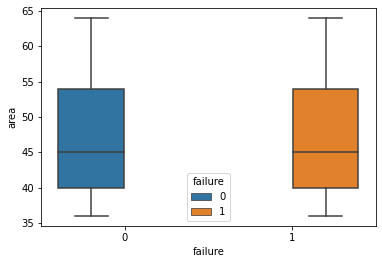

In [8]:
import matplotlib.pyplot as plt 
import seaborn as sns

sns.boxplot(data = train, y = 'area', x = 'failure', hue = 'failure')